<div style="float: right; width: 70%; height: 150px;">
  <div style="position: relative; top: 20%;padding-right:20%;">
  <div style="font-size:280%;font-weight: bold;padding-top: 20px;"> MARS</div>
  <div style="font-size:180%;font-weight: bold;padding-top: 20px;color: rgba(0 , 0 , 0 , 0.5);"> Download event waveforms of Marsquakes</div>
  </div>
</div>


This script will download a Mars seismogram from IRIS for one of largest marsquakes detected so far, event S0235b. 

## 0. Setup

Note: this python script requires extra packages for
    - matplotlib (version 2.1.2) : > pip install -U matplotlib
    - numpy      (version 1.14.0): > pip install -U numpy
    - obspy      (version 1.1.0) : > pip install -U obspy

In [1]:
from __future__ import print_function
import os,sys

# for fixed plots
%matplotlib inline
# for interactive plots
#%matplotlib notebook

import matplotlib as mpl
print("matplotlib version: ",mpl.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20, 5
plt.rcParams['lines.linewidth'] = 0.5

## numpy
import numpy as np
print("numpy version: ",np.__version__)

# do not show scipy warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib version:  3.5.1
numpy version:  1.21.0


uses obspy<br>
http://docs.obspy.org<br>
a python framework for seismology


In [2]:
import obspy

# additional functions
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy import read,read_events,read_inventory
from obspy.geodetics.base import gps2dist_azimuth

print("obspy version: ",obspy.__version__)

obspy version:  1.2.2


### Input Parameters


In [3]:
# user parameters
# duration of traces in s
duration = 60 * 30   # 30 min

# bandpass filter
# frequency range
bandpass_fmin = 1./8.       # 8s period   -> 0.1 Hz
bandpass_fmax = 1./1.4      # 1.4s period    -> 1 Hz




## Data download


In [4]:
# function to download data
def download_data(t0,event_dir):
    # gets data from IRIS data center
    global duration

    # duration
    #t1 = t0 + 60*60  # 60 min duration
    t1 = t0 + duration  # 60 min duration

    # client
    client = Client('IRIS')

    # catalog
    # shows multiple events... none for S0235b
    cat = client.get_events(starttime=t0, endtime=t1, minmagnitude=1.0)

    # inventory
    # location code: 02 - for high gain BH* up to 20 Hz
    #                03 - for high gain BH* up to 10 Hz
    inv = client.get_stations(network="XB", station="ELYSE", loc="02", channel="BH*", starttime=t0, endtime=t1, level="response")

    # waveform traces for high gain BH* (frequency up to 20 Hz)
    # see: https://www.iris.edu/hq/sis/insight#marsm
    st = client.get_waveforms("XB", "ELYSE", "*", "BH*", starttime=t0, endtime=t1, attach_response=True)

    # stores into event directory
    os.mkdir(event_dir)

    # catalog
    cat.write(event_dir + "/catalog.xml",format="QUAKEML")
    # inventory
    inv.write(event_dir + "/inventory.xml",format="STATIONXML")
    # station waveforms
    st.write(event_dir + "/waveforms.mseed",format="MSEED")

    print("  downloaded data to folder: ",event_dir)
    print("")

    return cat,inv,st


## Event time

for example:<br>
   * event S0235b<br>
   time 2019-07-26 12:15:17<br>
   see: http://ds.iris.edu/ds/nodes/dmc/tools/mars-events/<br>

   corrected origin time: 2019-07-26T12:15:38.748239Z from previous 2019-07-26T12:15:45.06956Z<br>
   see: http://ds.iris.edu/files/insight/v9/changelog_events_extended_multiorigin_v9_2021-10-01.log


 Low-frequency events (corrected origin times)<br>
   * S0235b : 2019-07-26T12:15:38.748239Z    - quality A  (see Clinton et al., 2020)<br>
   * S0173a : 2019-05-23T02:19:09.852879Z    - quality A<br>
   * S0183a : 2019-06-03T02:22:01.995079Z    - quality B<br>


In [5]:
# event time
event_time = "2019-07-26T12:15:38.748239Z"

t0 = UTCDateTime(event_time)

# event directory
event_dir = "event_" + str(t0)

# checks if stored already
if not os.path.isdir(event_dir):
    print("downloading data from IRIS...")
    # download data
    # catalog/inventory/station waveforms
    cat,inv,st = download_data(t0,event_dir)
else:
    print("reading data from event directory ",event_dir,"...")
    # read stored data
    cat = read_events(event_dir + "/catalog.xml")
    inv = read_inventory(event_dir + "/inventory.xml")
    st = read(event_dir + "/waveforms.mseed")

print("catalog:")
print(cat)
print("")
#if show: cat.plot()

print("inventory:")
print(inv)
print("")
#if show: inv.plot_response(0.001, station="ELYSE")

print("waveforms:")
print(st)
print("")



downloading data from IRIS...
  downloaded data to folder:  event_2019-07-26T12:15:38.748239Z

catalog:
9 Event(s) in Catalog:
2019-07-26T12:42:26.570000Z | +37.807, -113.202 | 1.59 Ml
2019-07-26T12:35:35.470000Z | +35.648, -117.505 | 1.52 Ml
2019-07-26T12:29:44.190000Z | +35.935, -117.701 | 1.32 Ml
2019-07-26T12:25:58.010000Z | +35.594, -117.428 | 1.36 Ml
2019-07-26T12:20:50.799000Z | +35.834,  -98.084 | 1.74 ML
2019-07-26T12:19:53.930000Z | +35.816, -117.606 | 1.24 Ml
2019-07-26T12:18:51.170000Z | +33.474, -116.585 | 1.13 Ml
2019-07-26T12:16:38.320000Z | +35.559, -117.444 | 1.71 Ml
2019-07-26T12:15:53.900000Z | +19.313, -155.221 | 1.83 Md

inventory:
Inventory created at 2022-03-28T18:57:50.076000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?location=02&starttim...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			XB
		Stations (1):
			XB.ELYSE (Elysium Planitia, Mars - Scientific data)
		C

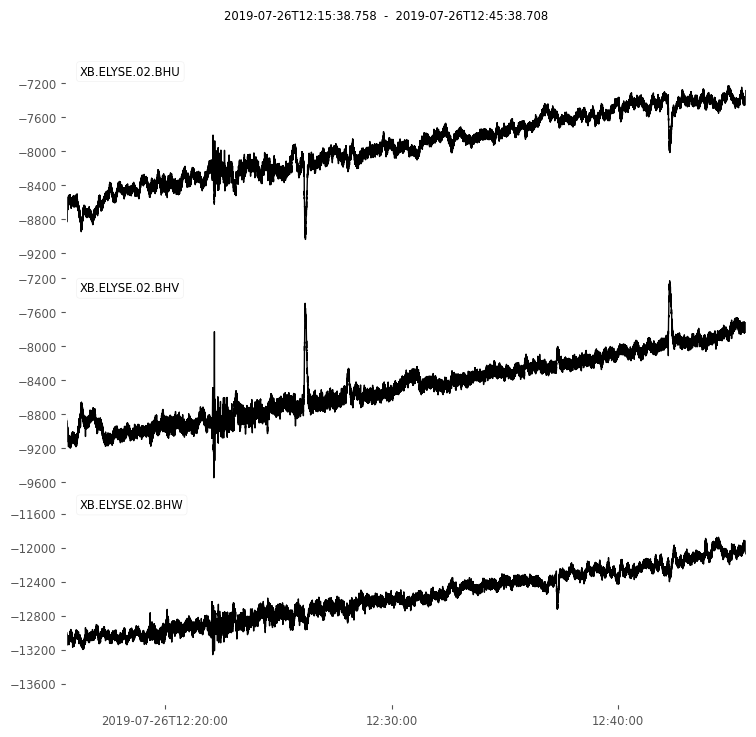

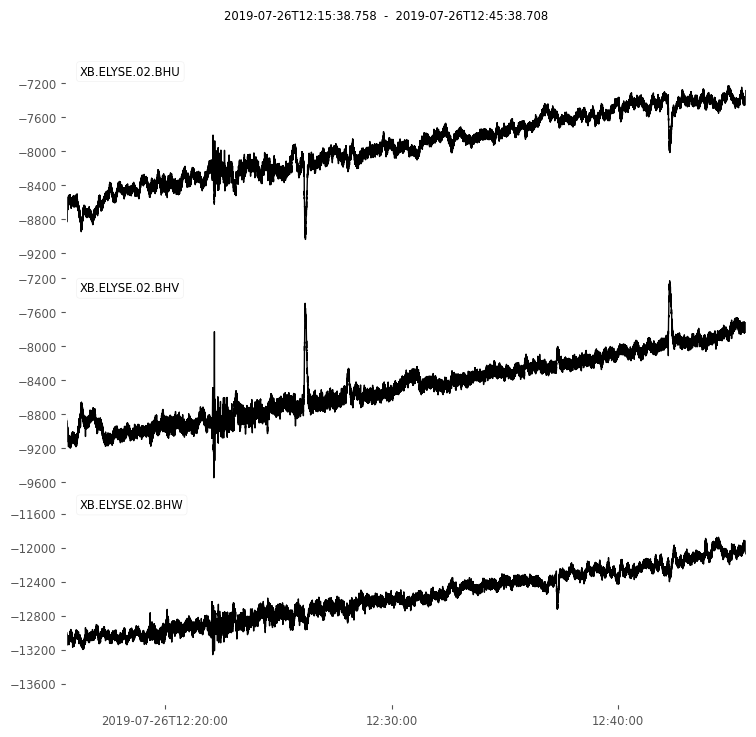

In [6]:
# plotting
st.plot()

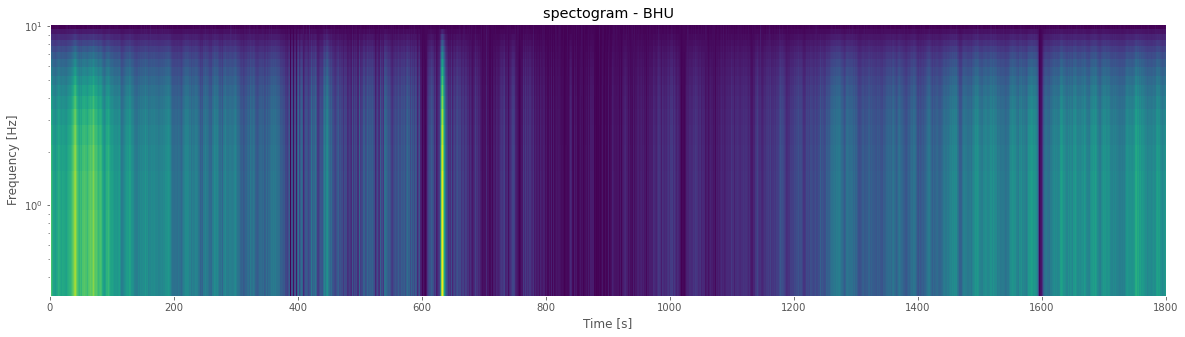

In [8]:
# spectrogram
st[0].spectrogram(log=True, title='spectogram - ' + str(st[0].stats.channel))

## Data processing

We get some basic trace information first, and then remove the instrument response.

Note that raw data from the InSight instrument contains artificial "glitches" and "spikes" mostly due to the extreme thermal conditions on Mars. A nice read about the detection of such glitches can be found here: [Schulz et al. 2020](https://doi.org/10.1029/2020EA001317) 
Their deglitching tool is avaiable here: [SEISglitch](https://pss-gitlab.math.univ-paris-diderot.fr/data-processing-wg/seisglitch)<br>

In our record section, multiple of these glitches occurred. We won't try to remove and correct those, but you will find the same event record section with areas taken out due to such glitches in figure 3 of this publication: [Duran et al. 2022](https://doi.org/10.1016/j.pepi.2022.106851)


In [9]:
print("processing waveform data...")

# trace info
tr = st[0]
dt = tr.stats.delta
npts = tr.stats.npts
t_max = npts * dt

freq_Ny = 1.0/(2.0 * dt)   # Nyquist frequency
freq_min = 1.0/t_max       # minimal possible frequency for length of trace

print("trace:")
print("  maximum duration = ",t_max,"s"," = ",t_max/60.,"min"," = ",t_max/60./60.,"h")
print("  Nyquist frequency = ",freq_Ny,"(Hz)")
print("  minimum frequency = ",freq_min,"(Hz)")
print("")



processing waveform data...
trace:
  maximum duration =  1800.0 s  =  30.0 min  =  0.5 h
  Nyquist frequency =  10.0 (Hz)
  minimum frequency =  0.0005555555555555556 (Hz)



In [10]:
# remove instrument response
# filter
filt = [1./200., 1./100., 8, 10] # basic for 20 Hz data

print("filtering output data ...")
t_1 = 1.0/bandpass_fmin
t_2 = 1.0/bandpass_fmax

# adds 20% for fall-off
t_max = t_1 + 0.2 * t_1
t_min = t_2 - 0.2 * t_2
print("  bandpass filter: fmin / fmax = {} / {} Hz".format(bandpass_fmin,bandpass_fmax))
print("                   Tmin / Tmax = {} / {} s".format(1.0/bandpass_fmax,1.0/bandpass_fmin))
print("                   extended t_min / t_max = {} / {} s".format(t_min,t_max))
print("")
filt = [1./t_max, bandpass_fmin, bandpass_fmax, 1./t_min] # for 20 Hz data

print("removing instrument reponse: output displacement ...")
st.remove_response(output='DISP',pre_filt=filt,taper_fraction=0.05,inventory=inv)
print(st)
print("")


filtering output data ...
  bandpass filter: fmin / fmax = 0.125 / 0.7142857142857143 Hz
                   Tmin / Tmax = 1.4 / 8.0 s
                   extended t_min / t_max = 1.1199999999999999 / 9.6 s

removing instrument reponse: output displacement ...
3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples
XB.ELYSE.02.BHV | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples
XB.ELYSE.02.BHW | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples



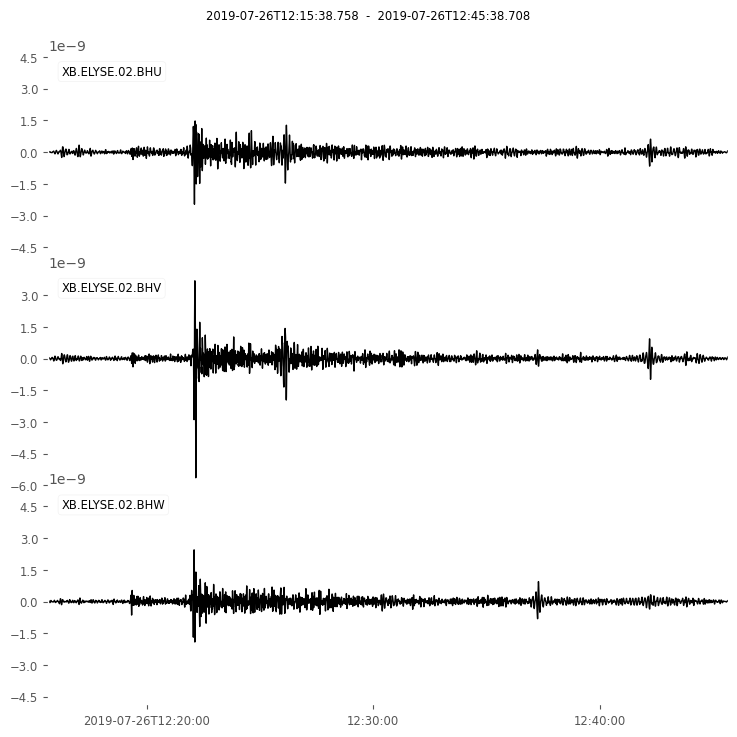

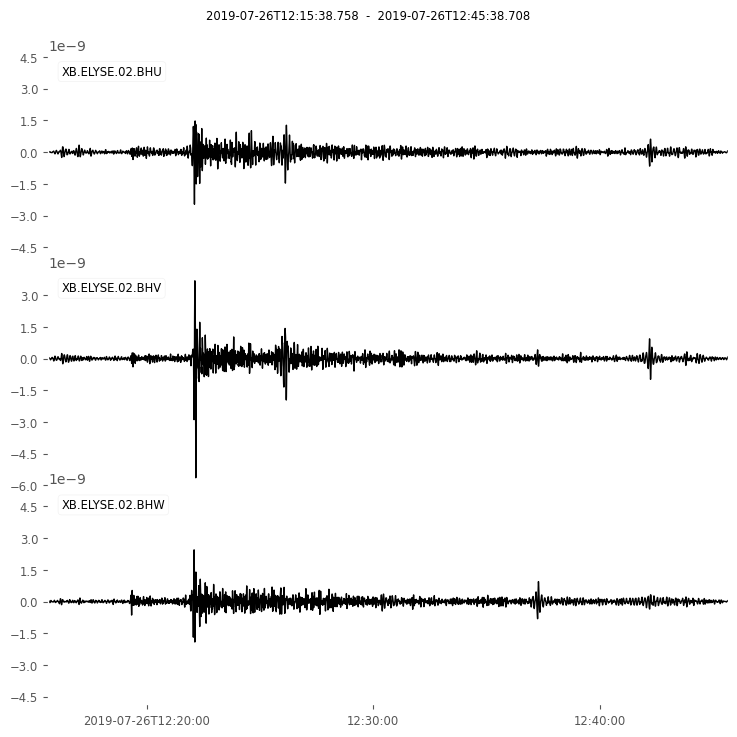

In [11]:
# plotting
st.plot()

Let's rotate the components to N/E/Z

In [12]:
# rotates to N/E/Z
print("rotating to ZNE ...")
st.rotate('->ZNE',inventory=inv)

# rename channels
st[0].stats.channel = 'BHZ'
st[1].stats.channel = 'BHN'
st[2].stats.channel = 'BHE'

# info
print(st)
print("")


rotating to ZNE ...
3 Trace(s) in Stream:
XB.ELYSE.02.BHZ | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples
XB.ELYSE.02.BHN | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples
XB.ELYSE.02.BHE | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples



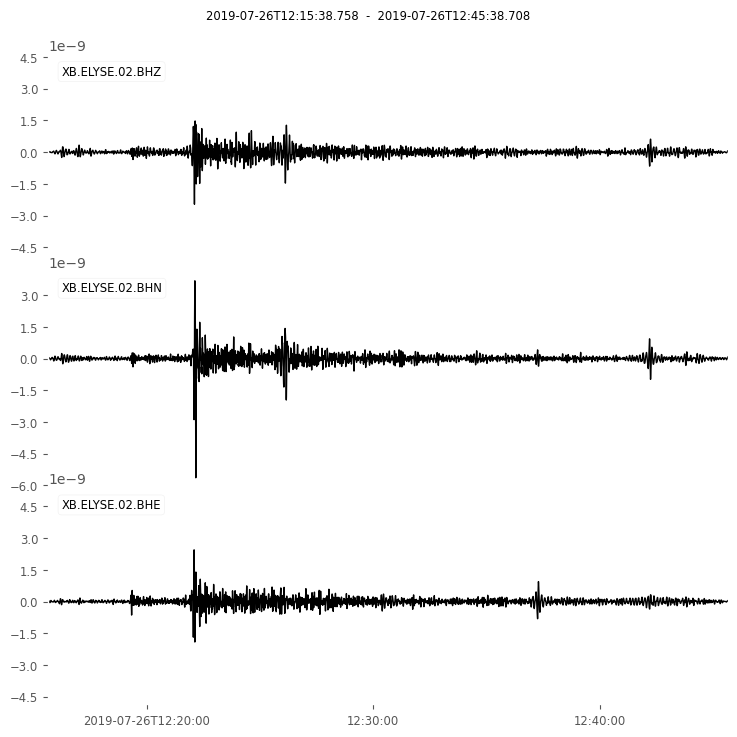

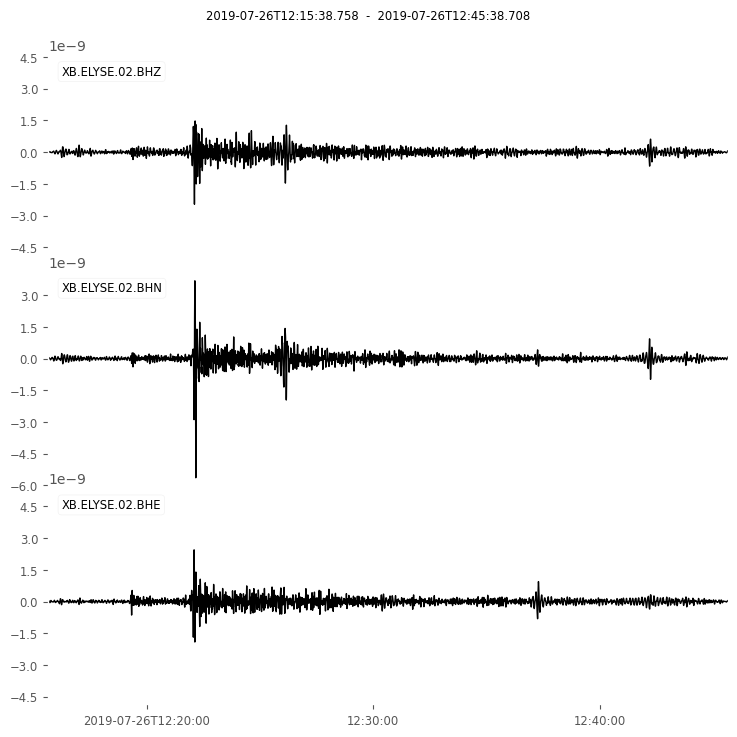

In [13]:
# plotting
st.plot()

In [14]:
# store files
print("storing data ...")
# TSPAIR format
#filename = 'data_all.tspair.ascii'
#print("saving all traces to file: %s" % (filename))
#st.write(filename, format='TSPAIR')

# ASCII format for gnuplot
for i, tr in enumerate(st):
    filename = "%s.%s.%s.data.ascii" % (tr.stats.network,tr.stats.station,tr.stats.channel)
    print("trace %i saving to file: %s" % (i,filename))
    t = np.arange(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.delta)
    print("  number of points: ",tr.stats.npts)
    print("  trace length (s): ",tr.stats.npts * tr.stats.delta)

    f = open(filename, "w")
    f.write("# %s\n" % (filename))
    f.write("# NETWORK: %s\n" % (tr.stats.network))
    f.write("# STATION: %s\n" % (tr.stats.station))
    f.write("# CHANNEL: %s\n" % (tr.stats.channel))
    f.write("# START_TIME: %s\n" % (str(tr.stats.starttime)))
    f.write("# SAMP_FREQ: %f\n" % (tr.stats.sampling_rate))
    f.write("# DELTA: %f\n" % (tr.stats.delta))
    f.write("# NDAT: %d\n" % (tr.stats.npts))
    for j in range(0,tr.stats.npts):
        f.write("%f\t%e\n" % (t[j],tr.data[j]))
    #np.savetxt(f, tr.data * calibration, fmt="%f")
    f.close()


storing data ...
trace 0 saving to file: XB.ELYSE.BHZ.data.ascii
  number of points:  36000
  trace length (s):  1800.0
trace 1 saving to file: XB.ELYSE.BHN.data.ascii
  number of points:  36000
  trace length (s):  1800.0
trace 2 saving to file: XB.ELYSE.BHE.data.ascii
  number of points:  36000
  trace length (s):  1800.0


Finally, let's rotate the horizontal component to align with the backazimuth of an estimated event location:

In [15]:
# rotates to event backazimuth
event_lat = 11.5900
event_lon = 163.7900

sta_elyse = inv[0][0]
station_lat = sta_elyse.latitude
station_lon = sta_elyse.longitude

# backazimuth & distance
result = gps2dist_azimuth(event_lat, event_lon, station_lat, station_lon)

epidist = result[0]  # distance in m
azi = result[1]      # azimuth in deg
baz = result[2]      # backazimuth in deg

print("station        : lat / lon = {} / {}".format(station_lat,station_lon))
print("estimated event: lat / lon = {} / {}".format(event_lat,event_lon))
print("")
print("  backazimuth         = ",baz,"(deg)")

st.rotate('NE->RT',back_azimuth=baz)

station        : lat / lon = 4.502384 / 135.623447
estimated event: lat / lon = 11.59 / 163.79

  backazimuth         =  74.10097834431576 (deg)


3 Trace(s) in Stream:
XB.ELYSE.02.BHZ | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples
XB.ELYSE.02.BHR | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples
XB.ELYSE.02.BHT | 2019-07-26T12:15:38.758000Z - 2019-07-26T12:45:38.708000Z | 20.0 Hz, 36000 samples

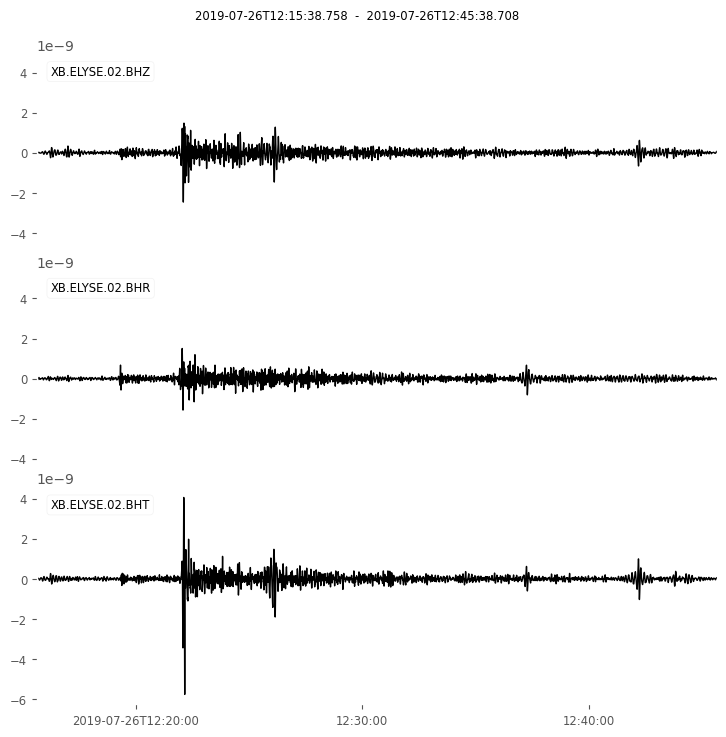

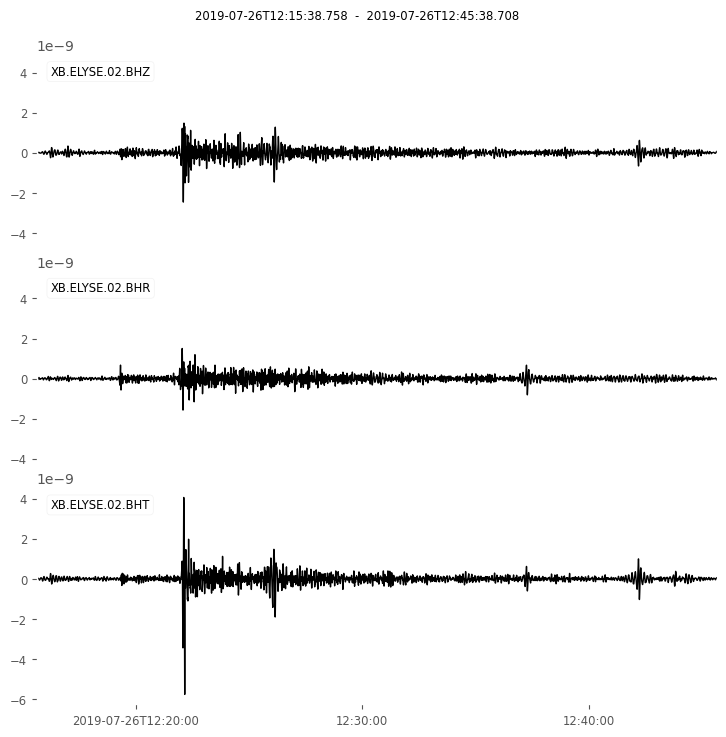

In [16]:
# plotting
st.plot()

## Amplitude spectrum

In [17]:
# vertical component
#tr = st.select(component="Z").copy() # in case stream has more components (E,N,Z)
tr = st[0].copy()   

# Frequency domain
FT = np.fft.rfft(tr.data)

# amplitude spectrum
FT = np.abs(FT)


plotting amplitude spectra...


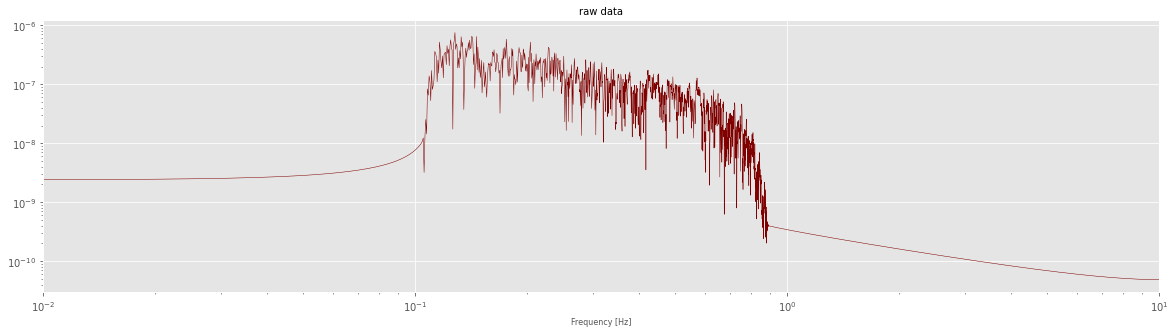

In [18]:
print("plotting amplitude spectra...")

# Frequency axis for plotting
freqs = np.fft.rfftfreq(tr.stats.npts, d=tr.stats.delta)

# Figure
plt.title("raw data",size=10)
plt.loglog(freqs, FT,color='maroon')
plt.xlim(1e-2, freq_Ny)
plt.xlabel("Frequency [Hz]",size=8)
#plt.legend()
plt.show()


done.